# Predicting flight delays (modelisation)
Pierre-Yves BOISBUNON - Decembre 2017


----------

The target is to predict flight delays based on the dataset **https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time**

In this notebook, we will try to find a model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1 Model

Let's reopen the dataset previously stored

In [2]:
import datetime
df = pd.read_csv('dataset_clean.csv', sep=',', error_bad_lines=False)

def import_datetime(chaine):
    return datetime.datetime.strptime(chaine, "%Y-%m-%d %H:%M:%S")

def import_time(chaine):
    raw = chaine.split(':')
    return datetime.time(int(raw[0]),int(raw[1]),int(raw[2]))

df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(import_time)
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(import_datetime)

In [3]:
df.columns

Index(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_ELAPSED_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'DISTANCE', 'ARRIVAL_DELAY'],
      dtype='object')

In [4]:
df_subset = df.copy(deep=True)

In [5]:
df_subset.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_ELAPSED_TIME,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DISTANCE,ARRIVAL_DELAY
0,EV,IAH,CRP,66.0,2016-01-06 17:35:00,18:41:00,201.0,9.0
1,B6,LGA,FLL,176.0,2016-01-17 21:40:00,00:36:00,1076.0,25.0
2,DL,MOB,ATL,74.0,2016-01-22 17:50:00,20:04:00,302.0,94.0
3,WN,CLE,BWI,80.0,2016-01-18 21:15:00,22:35:00,314.0,-10.0
4,OO,DEN,SLC,96.0,2016-01-17 15:19:00,16:55:00,391.0,8.0


## 1.1 Baseline

In order to compute our baseline, let's encode the categorical variables (**AIRLINE**, **ORIGIN_AIRPORT** and **DESTINATION_AIRPORT**) and convert **SCHEDULE_DEPARTURE** as a numeric value.

In [6]:
from sklearn import preprocessing
import datetime 
def convert_to_minute(x):
    return x.hour*60 + x.minute
    
df_train = pd.DataFrame()

# Label encoding
le_airline = preprocessing.LabelEncoder()
le_airline.fit(df_subset['AIRLINE'].unique())
df_train['AIRLINE'] = le_airline.transform(df_subset['AIRLINE'])

# Label encoding
le_origin_airport = preprocessing.LabelEncoder()
le_origin_airport.fit(df_subset['ORIGIN_AIRPORT'].unique())
df_train['ORIGIN_AIRPORT'] = le_origin_airport.transform(df_subset['ORIGIN_AIRPORT'])

# Label encoding
le_destination_airport = preprocessing.LabelEncoder()
le_destination_airport.fit(df_subset['DESTINATION_AIRPORT'].unique())
df_train['DESTINATION_AIRPORT'] = le_destination_airport.transform(df_subset['DESTINATION_AIRPORT'])

df_train['SCHEDULED_ELAPSED_TIME'] = df_subset['SCHEDULED_ELAPSED_TIME']
df_train['SCHEDULED_DEPARTURE'] = (df_subset['SCHEDULED_DEPARTURE'] - datetime.datetime(1970,1,1)).dt.total_seconds()
df_train['SCHEDULED_ARRIVAL'] = df_subset['SCHEDULED_ARRIVAL'].apply(convert_to_minute)
df_train['DISTANCE'] = df_subset['DISTANCE']
df_train['ARRIVAL_DELAY'] = df_subset['ARRIVAL_DELAY']

# Creer variable weekend
df_train.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_ELAPSED_TIME,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DISTANCE,ARRIVAL_DELAY
0,4,143,68,66.0,1.452102e+09,1121,201.0,9.0
1,2,173,105,176.0,1.453067e+09,36,1076.0,25.0
2,3,200,18,74.0,1.453485e+09,1204,302.0,94.0
3,11,61,49,80.0,1.453152e+09,1355,314.0,-10.0
4,8,78,275,96.0,1.453044e+09,1015,391.0,8.0


Let's see the mean value of **ARRIVAL_DELAY** in minutes

In [7]:
df_train['ARRIVAL_DELAY'].mean()

3.3652151877349326

Let's predict **ARRIVAL_DELAY**

In [8]:
from sklearn import preprocessing

X = df_train.as_matrix(df_train.columns[:-1])
X = preprocessing.normalize(X)
y = df_train.as_matrix([df_train.columns[-1]])
y = y.flatten()

In [9]:
from sklearn import preprocessing
from sklearn import model_selection

X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y,
test_size=0.3 # 30% des données dans le jeu de test
)

In [10]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
# The mean absolute error
print("Mean absolute error: %.2f (minutes)"
      % mean_absolute_error(y_test, y_pred))

Coefficients: 
 [-7.16036742e+07 -2.51763000e+04  7.24949448e+06 -1.26195165e+08
 -3.70570113e+11  1.62751015e+07  1.34310201e+07]
Variance score: 0.01
Mean absolute error: 21.00 (minutes)


We now have our baseline in minutes: **21 minutes**

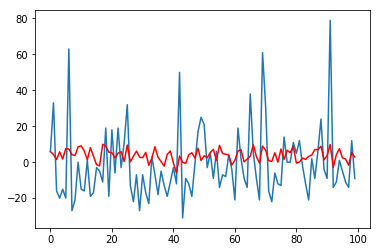

In [11]:
plt.plot(y_test[:100])
plt.plot(y_pred[:100], color='r')

# 1.2 Improve dataset

In [12]:
df_subset.columns

Index(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_ELAPSED_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'DISTANCE', 'ARRIVAL_DELAY'],
      dtype='object')

## 1.2.1 Feature engineering

As we have discovered during EDA, each variables (**AIRLINE**, **ORIGIN_AIRPORT**, **DESTINATION_AIRPORT**, scheduled month, scheduled day, scheduled hour and arrival date) plays a role in the arrival delay. Let's encode each one.

In [13]:
df_train = pd.DataFrame()

def encode_weekend(df, col):
    liste = []
    for index in df.index: 
        if pd.to_datetime(df[col].loc[index]).weekday() < 5:
            liste.append(0)
        else:
            liste.append(1)
    return liste

def encode_var(row, var, value, positive_value, negative_value):
    if row[var].find(value)> -1:
        return positive_value
    else:
        return negative_value
    
def binary_encode_var(row, var, value):
    return encode_var(row, var, value, 1, 0)

print ('start: ' +  str(datetime.datetime.now()))

# AIRLINE: one airline/one feature
airlines = df_subset['AIRLINE'].unique()
for airline in airlines:
    df_train['AIRL_' + airline] = df_subset.apply(lambda row: binary_encode_var(row, 'AIRLINE', airline), axis=1)

# ORIGIN_AIRPORT: one origin airport / one feature
airports = df_subset['ORIGIN_AIRPORT'].unique()
for airport in airports:
    df_train['ORIG_' + airport] = df_subset.apply(lambda row: binary_encode_var(row, 'ORIGIN_AIRPORT', airport), axis=1)

# DESTINATION_AIRPORT: one destination airport / one feature
destinations = df_subset['DESTINATION_AIRPORT'].unique()
for destination in destinations:
    df_train['DEST_' + destination] = df_subset.apply(lambda row: binary_encode_var(row, 'DESTINATION_AIRPORT', destination), axis=1)

df_train['SCHEDULED_DEPARTURE_MONTH'] = df_subset['SCHEDULED_DEPARTURE'].dt.month
df_train['SCHEDULED_DEPARTURE_DAY'] = df_subset['SCHEDULED_DEPARTURE'].dt.day
df_train['SCHEDULED_DEPARTURE_HOUR'] = df_subset['SCHEDULED_DEPARTURE'].dt.hour
df_train['SCHEDULED_DEPARTURE_MINUTE'] = df_subset['SCHEDULED_DEPARTURE'].dt.minute
df_train['SCHEDULED_DEPARTURE_SECOND'] = df_subset['SCHEDULED_DEPARTURE'].dt.second

df_train['IS_WEEKEND'] = encode_weekend(df_subset, 'SCHEDULED_DEPARTURE')

df_train['SCHEDULED_ARRIVAL_HOUR'] = df_subset['SCHEDULED_ARRIVAL'].apply(lambda x: x.hour)
df_train['SCHEDULED_ARRIVAL_MINUTE'] = df_subset['SCHEDULED_ARRIVAL'].apply(lambda x: x.minute)
df_train['SCHEDULED_ARRIVAL_SECONDE'] = df_subset['SCHEDULED_ARRIVAL'].apply(lambda x: x.second)

df_train['DISTANCE'] = df_subset['DISTANCE']

df_train['ARRIVAL_DELAY'] = df_subset['ARRIVAL_DELAY']

print ('end: ' + str(datetime.datetime.now()))

df_train.head()

start: 2018-11-19 22:39:34.454795
end: 2018-11-19 23:08:20.155891


,AIRL_EV,AIRL_B6,AIRL_DL,AIRL_WN,AIRL_OO,AIRL_F9,AIRL_AA,AIRL_UA,AIRL_NK,AIRL_VX,...,SCHEDULED_DEPARTURE_DAY,SCHEDULED_DEPARTURE_HOUR,SCHEDULED_DEPARTURE_MINUTE,SCHEDULED_DEPARTURE_SECOND,IS_WEEKEND,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MINUTE,SCHEDULED_ARRIVAL_SECONDE,DISTANCE,ARRIVAL_DELAY
0,1,0,0,0,0,0,0,0,0,0,...,6,17,35,0,0,18,41,0,201.0,9.0
1,0,1,0,0,0,0,0,0,0,0,...,17,21,40,0,1,0,36,0,1076.0,25.0
2,0,0,1,0,0,0,0,0,0,0,...,22,17,50,0,0,20,4,0,302.0,94.0
3,0,0,0,1,0,0,0,0,0,0,...,18,21,15,0,0,22,35,0,314.0,-10.0
4,0,0,0,0,1,0,0,0,0,0,...,17,15,19,0,1,16,55,0,391.0,8.0


In [14]:
df_train['SCHEDULED_ELAPSED_TIME'] = df_subset['SCHEDULED_ELAPSED_TIME']

## 3.2.2 Dealing with skew

Let's dealing with skew now

In [15]:
df_train_copy = df_train.copy(deep=True)
#df_train = df_train_copy.copy(deep=True)

In [16]:
from scipy.stats import skew
skew_values = []
cols = ['SCHEDULED_DEPARTURE_MONTH', 'SCHEDULED_DEPARTURE_DAY', 
        'SCHEDULED_DEPARTURE_HOUR', 'SCHEDULED_DEPARTURE_MINUTE', 'SCHEDULED_DEPARTURE_SECOND',
        'SCHEDULED_ELAPSED_TIME',
        'IS_WEEKEND',
        'SCHEDULED_ARRIVAL_HOUR', 'SCHEDULED_ARRIVAL_MINUTE', 'SCHEDULED_ARRIVAL_SECONDE',
        'DISTANCE', 'ARRIVAL_DELAY']
#cols = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'DISTANCE', 'ARRIVAL_DELAY']
for col in cols:
    skew_values = skew(df_train[cols])
my_df = pd.DataFrame({'index': cols, 'skew_values': skew_values})
my_df = my_df.sort_values('skew_values')
my_df

,index,skew_values
7,SCHEDULED_ARRIVAL_HOUR,-0.312376
1,SCHEDULED_DEPARTURE_DAY,-0.008092
4,SCHEDULED_DEPARTURE_SECOND,0.000000
9,SCHEDULED_ARRIVAL_SECONDE,0.000000
0,SCHEDULED_DEPARTURE_MONTH,0.001554
8,SCHEDULED_ARRIVAL_MINUTE,0.002731
3,SCHEDULED_DEPARTURE_MINUTE,0.048814
2,SCHEDULED_DEPARTURE_HOUR,0.063876
6,IS_WEEKEND,1.100277
5,SCHEDULED_ELAPSED_TIME,1.275019


**DISTANCE** and **ARRIVAL_DELAY** have the worst skew, let's try to solve this point!

In [17]:
from __future__ import division
from scipy.stats import boxcox

def display_skew(df, var):
    df.hist(column=var)
    print ('skewness: ' + str(skew(df[var])))
    
def remove_outliers(df, var):
    elements = df[var] 
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    test_df = pd.DataFrame()
    test_df = df[(df[var] > mean - 2 * sd) & (df[var] < mean + 2 * sd)]
    prev_len = len(df)
    new_len = len(test_df)
    diff_perc = 100 * ((prev_len - new_len) / prev_len)
    print ('len (before cleaning): ' + str(prev_len))
    print ('len (after cleaning): ' + str(new_len))
    print ('len (% removing): ' + str(diff_perc))
    return test_df

In [18]:
# https://stackoverflow.com/questions/26391454/reverse-box-cox-transformation
def invboxcox(y,ld, offset):
    if ld == 0:
        return (np.exp(y) - offset)
    else:
        return (np.exp(np.log(ld*y+1)/ld) - offset)

#### DISTANCE

Let's display the skew of **DISTANCE** variable

skewness: 1.3426669476879873


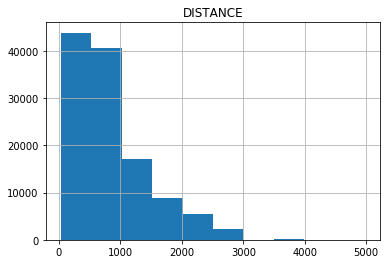

In [19]:
display_skew(df_train, 'DISTANCE')

Let's use Box Cox transformation to reduce the skew

skewness: -0.018429921273444484


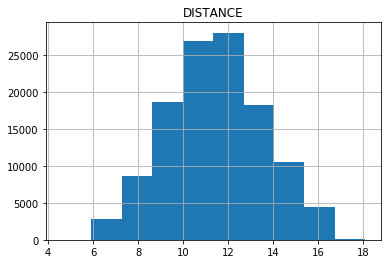

In [20]:
# Optimize skew with boxcox
res = boxcox(df_train['DISTANCE'])
df_train['DISTANCE'] = res[0]
coxbox_ld_distance = res[1]
display_skew(df_train, 'DISTANCE')

In [21]:
coxbox_ld_distance

0.15921412370657623

Done!

#### ARRIVAL_DELAY

Let's display the skew of **ARRIVAL_DELAY**

skewness: 7.914520511025244


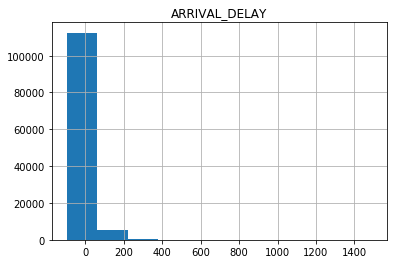

In [22]:
display_skew(df_train, 'ARRIVAL_DELAY')

len (before cleaning): 118385
len (after cleaning): 114274
len (% removing): 3.4725683152426403
skewness: 1.5441172165048562


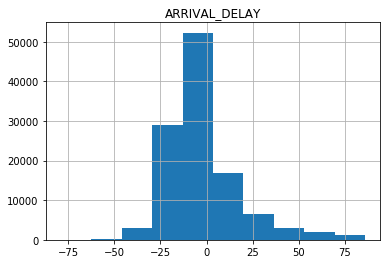

In [23]:
# Remove outliers first
df_train = remove_outliers(df_train, 'ARRIVAL_DELAY')
display_skew(df_train, 'ARRIVAL_DELAY')

skewness: -0.1108044037684048


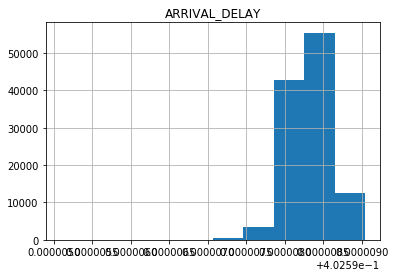

In [24]:
# Optimize skew with boxcox
coxbox_add_arrival_delay = abs(np.min(df_train['ARRIVAL_DELAY'])) + 100
res = boxcox(df_train['ARRIVAL_DELAY'] + coxbox_add_arrival_delay)
df_train['ARRIVAL_DELAY'] = res[0]
coxbox_ld_arrival_delay = res[1]
display_skew(df_train, 'ARRIVAL_DELAY')

In [27]:
coxbox_ld_arrival_delay, coxbox_add_arrival_delay

(-2.4838584691985517, 179.0)

We now have a clean dataset with variables correctly centered and outliers removed. Let's store all of them.

In [25]:
df_train.to_csv('dataset_modele.csv', index=False)